# VisualBert
https://huggingface.co/docs/transformers/model_doc/visual_bert

Transformer by huggingface"

page: https://www.libhunt.com/r/transformers

Github: https://github.com/huggingface/transformers

Installation

In [1]:
!pip install -q transformers wget

In [2]:
!git clone https://github.com/huggingface/transformers.git
%cd transformers/examples/research_projects/visual_bert

fatal: destination path 'transformers' already exists and is not an empty directory.
/content/transformers/examples/research_projects/visual_bert


In [3]:
from IPython.display import Image, display
import PIL.Image
import io
import torch
import numpy as np
from processing_image import Preprocess
from visualizing_image import SingleImageViz
from modeling_frcnn import GeneralizedRCNN
from utils import Config
import utils
from transformers import VisualBertForQuestionAnswering, BertTokenizerFast

# URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/images/input.jpg"
#URL = "https://vqa.cloudcv.org/media/test2014/COCO_test2014_000000262567.jpg"
URL = "https://miro.medium.com/max/992/1*7jn1sgbhz3fNJweDFTHrrw.png"
OBJ_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/objects_vocab.txt"
ATTR_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/attributes_vocab.txt"
VQA_URL = "https://dl.fbaipublicfiles.com/pythia/data/answers_vqa.txt"

# load object, attribute, and answer labels

objids = utils.get_data(OBJ_URL);
attrids = utils.get_data(ATTR_URL);
vqa_answers = utils.get_data(VQA_URL);

# load models and model components
frcnn_cfg = Config.from_pretrained("unc-nlp/frcnn-vg-finetuned")
frcnn = GeneralizedRCNN.from_pretrained("unc-nlp/frcnn-vg-finetuned", config=frcnn_cfg);
image_preprocess = Preprocess(frcnn_cfg);
images, sizes, scales_yx = image_preprocess(URL)

output_dict = frcnn(
    images,
    sizes,
    scales_yx=scales_yx,
    padding="max_detections",
    max_detections=frcnn_cfg.max_detections,
    return_tensors="pt",
)

bert_tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased");
visualbert_vqa = VisualBertForQuestionAnswering.from_pretrained("uclanlp/visualbert-vqa");

loading configuration file cache
%s not found in cache or force_download set to True, downloading to %s https://cdn.huggingface.co/unc-nlp/frcnn-vg-finetuned/pytorch_model.bin /root/.cache/torch/transformers/tmpp95yyn6p


Downloading:   0%|          | 0.00/262M [00:00<?, ?B/s]

loading weights file https://cdn.huggingface.co/unc-nlp/frcnn-vg-finetuned/pytorch_model.bin from cache at /root/.cache/torch/transformers/57f6df6abe353be2773f2700159c65615babf39ab5b48114d2b49267672ae10f.77b59256a4cf8343ae0f923246a81489fc8d82f98d082edc2d2037c977c0d9d0


/content/transformers/examples/research_projects/visual_bert/modeling_frcnn.py:1750: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(resolved_archive_f

All model checkpoint weights were used when initializing GeneralizedRCNN.

All the weights of GeneralizedRCNN were initialized from the model checkpoint at unc-nlp/frcnn-vg-finetuned.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GeneralizedRCNN for predictions without further training.


/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/153k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/455M [00:00<?, ?B/s]

In [4]:
test_questions_for_url2 = [
    "Where is the cat?",
    "What is near the disk?",
    "What is the color of the table?",
    "What is the color of the cat?",
    "What is the shape of the monitor?",
]

# Very important that the boxes are normalized
features = output_dict.get("roi_features")

for test_question in test_questions_for_url2:
    test_question = [test_question]

    inputs = bert_tokenizer(
        test_question,
        padding="max_length",
        max_length=20,
        truncation=True,
        return_token_type_ids=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors="pt",
    )

    output_vqa = visualbert_vqa(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        visual_embeds=features,
        visual_attention_mask=torch.ones(features.shape[:-1]),
        token_type_ids=inputs.token_type_ids,
        output_attentions=False,
    )
    # get prediction
    pred_vqa = output_vqa["logits"].argmax(-1)
    print("Question:", test_question)
    print("prediction from VisualBert VQA:", vqa_answers[pred_vqa])


Question: ['Where is the cat?']
prediction from VisualBert VQA: outside
Question: ['What is near the disk?']
prediction from VisualBert VQA: nothing
Question: ['What is the color of the table?']
prediction from VisualBert VQA: brown
Question: ['What is the color of the cat?']
prediction from VisualBert VQA: gray
Question: ['What is the shape of the monitor?']
prediction from VisualBert VQA: square


# Ablation
Using Lib

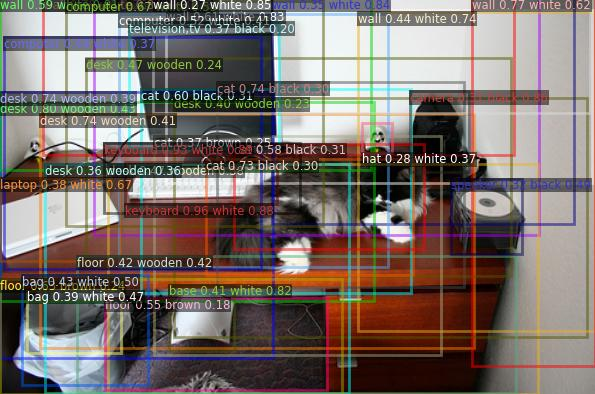

In [5]:
import matplotlib.pyplot as plt
from IPython.display import Image, display

URL = "https://miro.medium.com/max/992/1*7jn1sgbhz3fNJweDFTHrrw.png"
images, sizes, scales_yx = image_preprocess(URL)
output_dict = frcnn(
    images,
    sizes,
    scales_yx=scales_yx,
    padding="max_detections",
    max_detections=frcnn_cfg.max_detections,
    return_tensors="pt",
)

# for visualizing output
def showarray(a, fmt="jpeg"):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

# image viz
frcnn_visualizer = SingleImageViz(URL, id2obj=objids, id2attr=attrids)

# add boxes and labels to the image

frcnn_visualizer.draw_boxes(
    output_dict.get("boxes"),
    output_dict.pop("obj_ids"),
    output_dict.pop("obj_probs"),
    output_dict.pop("attr_ids"),
    output_dict.pop("attr_probs"),
)
showarray(frcnn_visualizer._get_buffer())



In [6]:
print('sizes:',sizes, 'scales_yx:',scales_yx)

frcnn_cfg = Config.from_pretrained("unc-nlp/frcnn-vg-finetuned")
print('Mean:',frcnn_cfg.MODEL.PIXEL_MEAN,
      '\nSTD:',frcnn_cfg.MODEL.PIXEL_STD,
      '\nMax Input Size:',frcnn_cfg.INPUT.MAX_SIZE_TEST,
      '\nMin Input Size:',frcnn_cfg.INPUT.MIN_SIZE_TEST)

print('ROI Feature Extraction Model:',frcnn_cfg.RESNETS)

sizes: tensor([[ 800, 1206]]) scales_yx: tensor([[0.4112, 0.4113]])
loading configuration file cache
Mean: [102.9801, 115.9465, 122.7717] 
STD: [1.0, 1.0, 1.0] 
Max Input Size: 1333 
Min Input Size: 800
ROI Feature Extraction Model: resnets:
    depth: 101 (int)
    out_features: ['res4'] (list)
    num_groups: 1 (int)
    norm: BN (str)
    width_per_group: 64 (int)
    stride_in_1x1: True (bool)
    res5_dilation: 1 (int)
    res2_out_channels: 256 (int)
    stem_out_channels: 64 (int)


In [9]:
from PIL import Image
import requests
URL = "https://miro.medium.com/max/992/1*7jn1sgbhz3fNJweDFTHrrw.png"
img = Image.open(requests.get(URL, stream=True).raw)
raw_sizes = torch.tensor(np.array(img).shape[:2])
sizes = torch.tensor([800, 1206])
scales_yx = torch.true_divide(raw_sizes, sizes)
print('raw_sizes, sizes, scales_yx:',raw_sizes, sizes, scales_yx)

raw_sizes, sizes, scales_yx: tensor([329, 496]) tensor([ 800, 1206]) tensor([0.4112, 0.4113])


W/O Lib (Ignoring resize Augmentation)

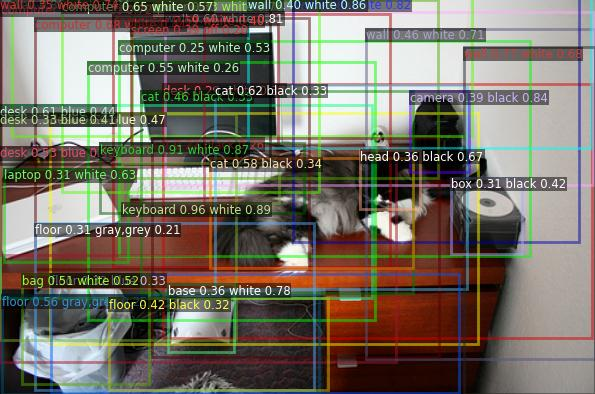

In [11]:
import matplotlib.pyplot as plt
from PIL import Image
import requests
import numpy as np
import torch

# Download and open image
URL = "https://miro.medium.com/max/992/1*7jn1sgbhz3fNJweDFTHrrw.png"
img_raw = Image.open(requests.get(URL, stream=True).raw)

# Convert to RGB if image has alpha channel
if img_raw.mode in ('RGBA', 'LA') or (img_raw.mode == 'P' and 'transparency' in img_raw.info):
    img_raw = img_raw.convert('RGB')

# Calculate scaling factors
raw_sizes = torch.tensor(np.array(img_raw).shape[:2])
sizes = torch.tensor([800, 1206])
scales_yx = torch.true_divide(raw_sizes, sizes)

# Resize image
pil_image = img_raw.resize((1206, 800), Image.BILINEAR)  # PIL image wxh where other lib hxw

# Define and apply normalization
def normalize_image(x):
    mean = np.array([102.9801, 115.9465, 122.7717])
    # Ensure broadcasting works correctly by adding axes
    mean = mean[None, None, :]
    return (x - mean) / [1.0, 1.0, 1.0]

# Convert to numpy array and normalize
image_array = np.array(pil_image)
normalized_image = normalize_image(image_array)

# Convert to tensor and reshape
images_mine = torch.tensor(normalized_image).double().permute(2, 0, 1)[None]

# Now you can proceed with your FRCNN processing
output_dict = frcnn(
    images_mine.float(),
    torch.tensor([[800, 1206]]),
    scales_yx=torch.tensor([[0.4112, 0.4113]]),
    padding="max_detections",
    max_detections=frcnn_cfg.max_detections,
    return_tensors="pt",
)

# Visualization code remains the same
def showarray(a, fmt="jpeg"):
    from IPython.display import Image, display
    import io
    import PIL
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

# Add boxes and labels to the image
frcnn_visualizer = SingleImageViz(URL, id2obj=objids, id2attr=attrids)
frcnn_visualizer.draw_boxes(
    output_dict.get("boxes"),
    output_dict.pop("obj_ids"),
    output_dict.pop("obj_probs"),
    output_dict.pop("attr_ids"),
    output_dict.pop("attr_probs"),
)
showarray(frcnn_visualizer._get_buffer())

Display all images:

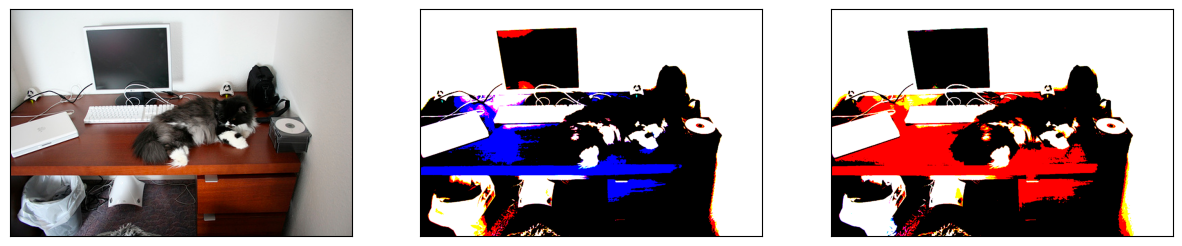

In [12]:
num_img = 3
fig, ax = plt.subplots(1, num_img, figsize=(5*num_img,5), subplot_kw=dict(xticks=[],yticks=[]))
ax[0].imshow(np.array(img_raw))
ax[1].imshow(images[0].permute(1,2,0))
ax[2].imshow(images_mine[0].permute(1,2,0))

VQA

In [13]:
features = output_dict.get("roi_features")
print('roi_features',features.shape)
inputs = bert_tokenizer(
        ["Where is the cat?"],
        padding="max_length",
        max_length=20,
        truncation=True,
        return_token_type_ids=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors="pt",
    )

print(inputs['attention_mask'].shape)
output_vqa = visualbert_vqa(
    input_ids=inputs.input_ids,
    attention_mask=inputs.attention_mask,
    visual_embeds=features,
    visual_attention_mask=torch.ones(features.shape[:-1]),
    token_type_ids=inputs.token_type_ids,
    output_attentions=False,
)

pred_vqa = output_vqa["logits"].argmax(-1)
print("Question:", test_question)
print("prediction from VisualBert VQA:", vqa_answers[pred_vqa])

roi_features torch.Size([1, 36, 2048])
torch.Size([1, 20])
Question: ['What is the shape of the monitor?']
prediction from VisualBert VQA: outside


In [14]:
from transformers import BertTokenizer, VisualBertModel, VisualBertForQuestionAnswering

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased");
model = VisualBertForQuestionAnswering.from_pretrained("uclanlp/visualbert-vqa");
model.num_labels = 2
model.cls = torch.nn.Linear(model.cls.in_features, 2)
text = "Who is eating the apple?"
inputs = tokenizer([text], return_tensors="pt", padding="max_length",max_length=20,);
print('Inputs Keys Before Visual Features:', inputs.keys())
visual_embeds = output_dict.get("roi_features")#.unsqueeze(0)
visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.float)

inputs.update(
    {
        "visual_embeds": visual_embeds,
        "visual_token_type_ids": visual_token_type_ids,
        "visual_attention_mask": visual_attention_mask,
    }
)

print('Inputs Keys After Visual Features:', inputs.keys())

labels = torch.tensor([[0.0, 1.0]]).unsqueeze(0)  # Batch size 1, Num labels 2
outputs = model(**inputs, labels=labels)
#loss = outputs.loss
scores = outputs.logits

Inputs Keys Before Visual Features: dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
Inputs Keys After Visual Features: dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'visual_embeds', 'visual_token_type_ids', 'visual_attention_mask'])


In [15]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased");
model = VisualBertForQuestionAnswering.from_pretrained("uclanlp/visualbert-vqa");

In [16]:
model.visual_bert.embeddings

VisualBertEmbeddings(
  (word_embeddings): Embedding(30522, 768, padding_idx=1)
  (position_embeddings): Embedding(512, 768)
  (token_type_embeddings): Embedding(2, 768)
  (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (visual_token_type_embeddings): Embedding(2, 768)
  (visual_position_embeddings): Embedding(512, 768)
  (visual_projection): Linear(in_features=2048, out_features=768, bias=True)
)

In [17]:
! pip -q install transformers

In [50]:
%cd transformers/examples/research_projects/visual_bert

import utils
VQA_URL = "https://dl.fbaipublicfiles.com/pythia/data/answers_vqa.txt"
vqa_answers = utils.get_data(VQA_URL);

/content/transformers/examples/research_projects/visual_bert


In [52]:
from IPython.display import Image, display
import PIL.Image
import io
import torch
import numpy as np
from transformers import VisualBertForQuestionAnswering, BertTokenizerFast, BertTokenizer
from PIL import Image
import requests
from utils import Config
from modeling_frcnn import GeneralizedRCNN

def seed_everything(seed=12):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything()

# Download image and convert to RGB
URL = "https://miro.medium.com/max/992/1*7jn1sgbhz3fNJweDFTHrrw.png"
img_raw = Image.open(requests.get(URL, stream=True).raw)
if img_raw.mode in ('RGBA', 'LA') or (img_raw.mode == 'P' and 'transparency' in img_raw.info):
    img_raw = img_raw.convert('RGB')

raw_sizes = torch.tensor(np.array(img_raw).shape[:2])
sizes = torch.tensor([800, 1206])
scales_yx = torch.true_divide(raw_sizes, sizes)

pil_image = img_raw.resize((1206, 800), Image.BILINEAR)

# Modified normalizer to handle broadcasting correctly
def normalize_image(x):
    mean = np.array([102.9801, 115.9465, 122.7717])
    mean = mean[None, None, :]  # Add dimensions for broadcasting
    return (x - mean) / [1.0, 1.0, 1.0]

# Convert to numpy array, normalize, and convert to tensor
image_array = np.array(pil_image)
normalized_image = normalize_image(image_array)
images_mine = torch.tensor(normalized_image).double().permute(2, 0, 1)[None]

# Load FRCNN model and get features
frcnn_cfg = Config.from_pretrained("unc-nlp/frcnn-vg-finetuned")
frcnn = GeneralizedRCNN.from_pretrained("unc-nlp/frcnn-vg-finetuned", config=frcnn_cfg)

output_dict = frcnn(
    images_mine.float(),
    torch.tensor([[800, 1206]]),
    scales_yx=torch.tensor([[0.4112, 0.4113]]),
    padding="max_detections",
    max_detections=frcnn_cfg.max_detections,
    return_tensors="pt",
)

print('roi_features:', output_dict.get("roi_features").shape,
      'boxes:', output_dict.get("boxes").shape,
      'obj_ids:', output_dict.get("obj_ids").shape,
      'attr_ids:', output_dict.get("attr_ids").shape)

# Prepare question input
test_question = ["Where is the cat?"]
bert_tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
inputs = bert_tokenizer(
    test_question,
    padding="max_length",
    max_length=20,
    truncation=True,
    return_token_type_ids=True,
    return_attention_mask=True,
    add_special_tokens=True,
    return_tensors="pt",
)

# Load VisualBERT model
model = VisualBertForQuestionAnswering.from_pretrained("uclanlp/visualbert-vqa")

print('Inputs Keys Before Visual Features:', inputs.keys())

# Prepare visual features
visual_embeds = output_dict.get("roi_features")
visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.float)

# Update inputs with visual features
inputs.update({
    "visual_embeds": visual_embeds,
    "visual_token_type_ids": visual_token_type_ids,
    "visual_attention_mask": visual_attention_mask,
})

print('Inputs Keys After Visual Features:', inputs.keys())

# Model prediction
model.eval()
with torch.no_grad():
    outputs = model(**inputs, labels=None)
    logits = outputs.logits

    # Get probabilities
    probs = torch.nn.functional.softmax(logits, dim=-1)

    # Get top 3 predictions and their probabilities
    top_probs, top_indices = torch.topk(probs, k=3)

    print("\nQuestion:", test_question[0])
    print("\nTop 3 predictions and their probabilities:")
    for prob, idx in zip(top_probs[0], top_indices[0]):
        print(f"Index {idx.item()}: probability {prob:.3f}")

    # Print model output details for debugging
    print("\nDebug information:")
    print(f"Logits shape: {logits.shape}")
    print(f"Number of classes: {logits.shape[-1]}")
    print(f"Max prediction index: {torch.argmax(logits, dim=-1).item()}")

loading configuration file cache
loading weights file https://cdn.huggingface.co/unc-nlp/frcnn-vg-finetuned/pytorch_model.bin from cache at /root/.cache/torch/transformers/57f6df6abe353be2773f2700159c65615babf39ab5b48114d2b49267672ae10f.77b59256a4cf8343ae0f923246a81489fc8d82f98d082edc2d2037c977c0d9d0


/content/transformers/examples/research_projects/visual_bert/modeling_frcnn.py:1750: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(resolved_archive_f

All model checkpoint weights were used when initializing GeneralizedRCNN.

All the weights of GeneralizedRCNN were initialized from the model checkpoint at unc-nlp/frcnn-vg-finetuned.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GeneralizedRCNN for predictions without further training.
roi_features: torch.Size([1, 36, 2048]) boxes: torch.Size([1, 36, 4]) obj_ids: torch.Size([1, 36]) attr_ids: torch.Size([1, 36])
Inputs Keys Before Visual Features: dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
Inputs Keys After Visual Features: dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'visual_embeds', 'visual_token_type_ids', 'visual_attention_mask'])

Question: Where is the cat?

Top 3 predictions and their probabilities:
Index 1989: probability 0.201
Index 1842: probability 0.149
Index 1488: probability 0.149

Debug information:
Logits shape: torch.Size([1, 3129])
Number of classes: 3129
Max prediction index: 1989

In [53]:
from torch import nn
from transformers import VisualBertModel, VisualBertConfig
class VisualBERT_VQA(nn.Module):
    def __init__(self, num_labels=2):
        super(VisualBERT_VQA, self).__init__()
        self.config = VisualBertConfig.from_pretrained("uclanlp/visualbert-vqa-coco-pre")
        #config.num_labels = 2
        self.visualbertvqa = VisualBertForQuestionAnswering(self.config).from_pretrained("uclanlp/visualbert-vqa");
        #self.visualbertvqa.num_labels = 2
        #self.visualbertvqa.cls = torch.nn.Linear(self.visualbertvqa.cls.in_features, 2)


    def forward(self, inputs):
        logits = self.visualbertvqa(**inputs, labels=None)
        return logits

seed_everything()
model_vqa = VisualBERT_VQA(num_labels=2)
model.eval()
outputs = model(**inputs, labels=None)
#loss = outputs.loss
logits = outputs.logits
pred_vqa = logits.argmax(-1)
print("Question:", test_question)
print("prediction from VisualBert VQA:", vqa_answers[pred_vqa])

Question: ['Where is the cat?']
prediction from VisualBert VQA: outside


In [54]:
from torch import nn
from transformers import VisualBertModel, VisualBertConfig
class VisualBERT_VQA(nn.Module):
    def __init__(self, num_labels=2):
        super(VisualBERT_VQA, self).__init__()
        self.config = VisualBertConfig.from_pretrained("uclanlp/visualbert-vqa-coco-pre")
        #config.num_labels = 2
        self.visualbertvqa = VisualBertForQuestionAnswering(self.config).from_pretrained("uclanlp/visualbert-vqa");
        #self.visualbertvqa.num_labels = 2
        #self.visualbertvqa.cls = torch.nn.Linear(self.visualbertvqa.cls.in_features, 2)


    def forward(self, inputs):
        logits = self.visualbertvqa(
            input_ids=inputs['input_ids'],
            token_type_ids=inputs['token_type_ids'],
            attention_mask=inputs['attention_mask'],
            visual_embeds=inputs['visual_embeds'],
            visual_token_type_ids=inputs['visual_token_type_ids'],
            visual_attention_mask=inputs['visual_attention_mask'],
        )
        return logits

seed_everything()
model_vqa = VisualBERT_VQA(num_labels=2)
model.eval()
outputs = model(**inputs, labels=None)
#loss = outputs.loss
logits = outputs.logits
pred_vqa = logits.argmax(-1)
print("Question:", test_question)
print("prediction from VisualBert VQA:", vqa_answers[pred_vqa])

Question: ['Where is the cat?']
prediction from VisualBert VQA: outside


In [55]:
from torch import nn
from transformers import VisualBertModel, VisualBertConfig
class VisualBERT_VQA(nn.Module):
    def __init__(self, num_labels=2):
        super(VisualBERT_VQA, self).__init__()
        self.config = VisualBertConfig.from_pretrained("uclanlp/visualbert-vqa-coco-pre")
        #config.num_labels = 2
        self.visualbertvqa = VisualBertForQuestionAnswering(self.config).from_pretrained("uclanlp/visualbert-vqa");
        #self.visualbertvqa.num_labels = 2
        #self.visualbertvqa.cls = torch.nn.Linear(self.visualbertvqa.cls.in_features, 2)

    def forward(self, inputs):
        #logits = self.visualbertvqa(**inputs, labels=None)
        #logits = model(**inputs, labels=None)
        # logits = self.visualbertvqa(
        #     input_ids=inputs['input_ids'],
        #     token_type_ids=inputs['token_type_ids'],
        #     attention_mask=inputs['attention_mask'],
        #     visual_embeds=inputs['visual_embeds'],
        #     visual_token_type_ids=inputs['visual_token_type_ids'],
        #     visual_attention_mask=inputs['visual_attention_mask'],
        # )

        embedding_output = self.visualbertvqa.visual_bert.embeddings(
            input_ids=inputs['input_ids'],
            token_type_ids=inputs['token_type_ids'],
            position_ids=None,
            inputs_embeds=None,
            visual_embeds=inputs['visual_embeds'],
            visual_token_type_ids=inputs['visual_token_type_ids'],
            image_text_alignment=None,
        )
        visual_input_shape = inputs['visual_embeds'].size()[:-1]
        input_shape = inputs['input_ids'].size()
        batch_size, seq_length  = input_shape
        combined_attention_mask = torch.cat((inputs['attention_mask'], inputs['visual_attention_mask']), dim=-1)
        extended_attention_mask: torch.Tensor = self.visualbertvqa.visual_bert.get_extended_attention_mask(
            combined_attention_mask, (batch_size, input_shape + visual_input_shape)
        )
        head_mask = None
        head_mask = self.visualbertvqa.visual_bert.get_head_mask(head_mask, self.config.num_hidden_layers)
        output_attentions, output_hidden_states = self.config.output_attentions, self.config.output_hidden_states
        return_dict = self.config.use_return_dict
        encoder_outputs = self.visualbertvqa.visual_bert.encoder(
            embedding_output,
            attention_mask=extended_attention_mask,
            head_mask=head_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = encoder_outputs[0]
        pooled_output = self.visualbertvqa.visual_bert.pooler(sequence_output)
        outputs = (sequence_output, pooled_output) + encoder_outputs[1:]

        sequence_output = outputs[0]
        # Get the index of the last text token
        # TO-CHECK: From the original code
        index_to_gather = inputs['attention_mask'].sum(1) - 2  # as in original code
        index_to_gather = (
            index_to_gather.unsqueeze(-1).unsqueeze(-1).expand(index_to_gather.size(0), 1, sequence_output.size(-1))
        )
        pooled_output = torch.gather(sequence_output, 1, index_to_gather)
        pooled_output = self.visualbertvqa.dropout(pooled_output)
        logits = self.visualbertvqa.cls(pooled_output)
        reshaped_logits = logits.view(-1, self.visualbertvqa.num_labels)
        #output = (reshaped_logits,) + outputs[2:]
        return reshaped_logits

seed_everything()
model_vqa = VisualBERT_VQA(num_labels=2)
model_vqa.eval()
logits = model_vqa(inputs)
print(logits[0,:3])
pred_vqa = logits.argmax(-1)
print("Question:", test_question)
print("prediction from VisualBert VQA:", vqa_answers[pred_vqa])


tensor([-6.6768,  1.1085, -2.5796], grad_fn=<SliceBackward0>)
Question: ['Where is the cat?']
prediction from VisualBert VQA: outside


In [56]:
class VisualBERT_VQA(nn.Module):
    def __init__(self, num_labels=2):
        super(VisualBERT_VQA, self).__init__()
        self.config = VisualBertConfig.from_pretrained("uclanlp/visualbert-vqa-coco-pre")
        self.visualbertvqa = VisualBertForQuestionAnswering(self.config).from_pretrained("uclanlp/visualbert-vqa");
        self.embeddings = self.visualbertvqa.visual_bert.embeddings
        self.visual_bert_encoder = self.visualbertvqa.visual_bert.encoder
        self.get_head_mask = self.visualbertvqa.visual_bert.get_head_mask
        self.pooler = self.visualbertvqa.visual_bert.pooler
        self.dropout = self.visualbertvqa.dropout
        self.cls = self.visualbertvqa.cls
        self.num_labels = self.visualbertvqa.num_labels

    def forward(self, inputs):
        embedding_output = self.embeddings(
            input_ids=inputs['input_ids'],
            token_type_ids=inputs['token_type_ids'],
            position_ids=None,
            inputs_embeds=None,
            visual_embeds=inputs['visual_embeds'],
            visual_token_type_ids=inputs['visual_token_type_ids'],
            image_text_alignment=None,
        )
        visual_input_shape = inputs['visual_embeds'].size()[:-1]
        input_shape = inputs['input_ids'].size()
        batch_size, seq_length  = input_shape
        combined_attention_mask = torch.cat((inputs['attention_mask'], inputs['visual_attention_mask']), dim=-1)
        extended_attention_mask: torch.Tensor = self.visualbertvqa.visual_bert.get_extended_attention_mask(
            combined_attention_mask, (batch_size, input_shape + visual_input_shape)
        )
        head_mask = None
        head_mask = self.get_head_mask(head_mask, self.config.num_hidden_layers)
        output_attentions, output_hidden_states = self.config.output_attentions, self.config.output_hidden_states
        return_dict = self.config.use_return_dict
        encoder_outputs = self.visual_bert_encoder(
            embedding_output,
            attention_mask=extended_attention_mask,
            head_mask=head_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = encoder_outputs[0]
        pooled_output = self.pooler(sequence_output)
        outputs = (sequence_output, pooled_output) + encoder_outputs[1:]

        sequence_output = outputs[0]
        # Get the index of the last text token
        # TO-CHECK: From the original code
        index_to_gather = inputs['attention_mask'].sum(1) - 2  # as in original code
        index_to_gather = (
            index_to_gather.unsqueeze(-1).unsqueeze(-1).expand(index_to_gather.size(0), 1, sequence_output.size(-1))
        )
        pooled_output = torch.gather(sequence_output, 1, index_to_gather)
        pooled_output = self.dropout(pooled_output)
        logits = self.cls(pooled_output)
        reshaped_logits = logits.view(-1, self.num_labels)
        #output = (reshaped_logits,) + outputs[2:]
        return reshaped_logits

seed_everything()
model_vqa = VisualBERT_VQA(num_labels=2)
model_vqa.eval()
logits = model_vqa(inputs)
print(logits[0,:3])
pred_vqa = logits.argmax(-1)
print("Question:", test_question)
print("prediction from VisualBert VQA:", vqa_answers[pred_vqa])

tensor([-6.6768,  1.1085, -2.5796], grad_fn=<SliceBackward0>)
Question: ['Where is the cat?']
prediction from VisualBert VQA: outside


# Embedding from Scratch

In [57]:
from torch import nn
from transformers import VisualBertModel, VisualBertConfig

# Initializing a VisualBERT visualbert-vqa-coco-pre style configuration
config = VisualBertConfig.from_pretrained("uclanlp/visualbert-vqa-coco-pre")
class VisualBertEmbeddings(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.word_embeddings = nn.Embedding(config.vocab_size, config.hidden_size, padding_idx=config.pad_token_id)
        self.position_embeddings = nn.Embedding(config.max_position_embeddings, config.hidden_size)
        self.token_type_embeddings = nn.Embedding(config.type_vocab_size, config.hidden_size)
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.register_buffer("position_ids", torch.arange(config.max_position_embeddings).expand((1, -1)))

        # For Visual Features
        # Token type and position embedding for image features
        self.visual_token_type_embeddings = nn.Embedding(config.type_vocab_size, config.hidden_size)
        self.visual_position_embeddings = nn.Embedding(config.max_position_embeddings, config.hidden_size)

        if config.special_visual_initialize:
            self.visual_token_type_embeddings.weight.data = nn.Parameter(
                self.token_type_embeddings.weight.data.clone(), requires_grad=True
            )
            self.visual_position_embeddings.weight.data = nn.Parameter(
                self.position_embeddings.weight.data.clone(), requires_grad=True
            )

        self.visual_projection = nn.Linear(config.visual_embedding_dim, config.hidden_size)


    def forward(
        self,
        input_ids=None,
        token_type_ids=None,
        position_ids=None,
        inputs_embeds=None,
        visual_embeds=None,
        visual_token_type_ids=None,
        image_text_alignment=None,
    ):

        input_shape = input_ids.size()
        seq_length = input_shape[1]
        if position_ids is None:
            position_ids = self.position_ids[:, :seq_length]

        print('bef', input_ids.shape)
        if inputs_embeds is None:
            inputs_embeds = self.word_embeddings(input_ids)

        print('af', inputs_embeds.shape)

        print('token_type_ids', token_type_ids.shape)
        token_type_embeddings = self.token_type_embeddings(token_type_ids)
        print('token_type_embeddings', token_type_embeddings.shape)
        embeddings = inputs_embeds + token_type_embeddings

        # Absolute Position Embeddings
        position_embeddings = self.position_embeddings(position_ids)
        embeddings += position_embeddings

        print('before:',visual_embeds.shape)
        visual_embeds = self.visual_projection(visual_embeds)
        print('after:',visual_embeds.shape)
        print('bef', visual_token_type_ids.shape)
        visual_token_type_embeddings = self.visual_token_type_embeddings(visual_token_type_ids)
        print('af', visual_token_type_embeddings.shape)
        visual_position_ids = torch.zeros(
            *visual_embeds.size()[:-1], dtype=torch.long, device=visual_embeds.device
        )
        print('bef',visual_position_ids.shape)
        visual_position_embeddings = self.visual_position_embeddings(visual_position_ids)
        print('bef',visual_position_embeddings.shape)
        visual_embeddings = visual_embeds + visual_position_embeddings + visual_token_type_embeddings
        print('visual_embeddings', visual_embeddings.shape)
        embeddings = torch.cat((embeddings, visual_embeddings), dim=1)

        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings

# Other modules

In [58]:
from torch import Tensor, device, nn
from typing import Any, Callable, Dict, List, Optional, Tuple, Union
import warnings

def get_extended_attention_mask(
    self, attention_mask: Tensor, input_shape: Tuple[int], device: device = None, dtype: torch.float = None
) -> Tensor:
    if dtype is None:
        dtype = self.dtype

    if not (attention_mask.dim() == 2 and self.config.is_decoder):
        # show warning only if it won't be shown in `create_extended_attention_mask_for_decoder`
        if device is not None:
            warnings.warn(
                "The `device` argument is deprecated and will be removed in v5 of Transformers.", FutureWarning
            )
    # We can provide a self-attention mask of dimensions [batch_size, from_seq_length, to_seq_length]
    # ourselves in which case we just need to make it broadcastable to all heads.
    if attention_mask.dim() == 3:
        extended_attention_mask = attention_mask[:, None, :, :]
    elif attention_mask.dim() == 2:
        # Provided a padding mask of dimensions [batch_size, seq_length]
        # - if the model is a decoder, apply a causal mask in addition to the padding mask
        # - if the model is an encoder, make the mask broadcastable to [batch_size, num_heads, seq_length, seq_length]
        if self.config.is_decoder:
            extended_attention_mask = ModuleUtilsMixin.create_extended_attention_mask_for_decoder(
                input_shape, attention_mask, device
            )
        else:
            extended_attention_mask = attention_mask[:, None, None, :]
    else:
        raise ValueError(
            f"Wrong shape for input_ids (shape {input_shape}) or attention_mask (shape {attention_mask.shape})"
        )

    extended_attention_mask = extended_attention_mask.to(dtype=dtype)  # fp16 compatibility
    extended_attention_mask = (1.0 - extended_attention_mask) * torch.finfo(dtype).min
    return extended_attention_mask

def get_head_mask(
    self, head_mask: Optional[Tensor], num_hidden_layers: int, is_attention_chunked: bool = False
) -> Tensor:
    if head_mask is not None:
        head_mask = self._convert_head_mask_to_5d(head_mask, num_hidden_layers)
        if is_attention_chunked is True:
            head_mask = head_mask.unsqueeze(-1)
    else:
        head_mask = [None] * num_hidden_layers

    return head_mask